## **Part 1: Implementing a CSR matrix**


### **First Task**
Make a copy of the code snippet and **implement the methods** \__init__, \__add__ and matvec.


In [ ]:
# Importing relevant modules
import numpy as np
import matplotlib.pylab as plt
import scipy
from scipy.sparse.linalg import LinearOperator
from scipy.sparse import coo_matrix

from timeit import timeit
import numba
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import cg

from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng


In [ ]:
from scipy.sparse.linalg import LinearOperator
import numpy as np
class CSRMatrix(LinearOperator):
    def __init__(self, coo_matrix):

        "COO matrix to CSR matrix conversion"

        # Within a constructor, performing attribute initialisation
        self.shape = coo_matrix.shape
        self.dtype = coo_matrix.dtype

        # Extracting the COO data (row,column,data), we have a Scipy COO matrix
        # which is an object so we can extract data using .row, .col, .data
        row = coo_matrix.row
        column = coo_matrix.col
        data = coo_matrix.data

        #As we are converting to CSR, we need to sort the row into correct order
        #and then the row, column & data order will follow the corrected order

        sorted_order = np.argsort(row)
        row = row[sorted_order]
        column = column[sorted_order]
        data = data[sorted_order]

        # In CSR, the indices are the column of the COO matrix & the index
        # pointer is required to tell us which column element are included
        # in every row

        # We assume there is always an element in every row hence the first
        # index pointer is 0
        indptr = [0]
        point = 0

        # Iterate through the ordered row list and count the number of repeated
        # index and add to the point and then append to the index pointer
        for i in range(0, self.shape[0]-1):
            point += np.count_nonzero(row == i)
            indptr.append(point)
        indptr.append(len(row))
        # attribute initialisation (CSR)
        self.indptr = indptr
        self.indices = column
        self.data = data


    def __add__(self,other):
        """Add the CSR matrix other to this matrix."""

        # Condition for a valid matrix addition is that both matrices must have
        # the same shape

        # we have initialised the attribute of the previous CSR matrix
        assert self.shape == other.shape

        # Here, we adopt the idea of first converting both CSR matrices to COO
        # matrices and perform addition computation and then convert back to CSR

        # matrix 1 to COO matrix
        indices1 = self.indices
        indptr1 = self.indptr
        data1 = self.data

        column_1 = indices1

        row_1 = []
        # Index pointer always have one more element than NO. rows
        num_rows_1 = len(indptr1) -1
        for i in range(num_rows_1):
            row_1.extend([i]*(indptr1[i+1]-indptr1[i]))
        row_1 = np.array(row_1,dtype=int)

        # matrix 2 to COO matrix

        indptr2 = other.indptr
        indices2 = other.indices
        data2 = other.data

        column_2 = indices2
        row_2 = []
        # Index pointer always have one more element than NO. rows
        num_rows_2 = len(indptr2) -1
        for i in range(num_rows_2):
            row_2.extend([i]*(indptr2[i+1]-indptr2[i]))
        row_2 = np.array(row_2,dtype=int)

        # Add COO matrices


        # Combine rows, columns, and data
        rows = np.concatenate([row_1, row_2])
        cols = np.concatenate([column_1, column_2])
        data = np.concatenate([data1, data2])

        # Sort by (row, col) using lexsort
        sorted_indices = np.lexsort((cols, rows))
        rows = rows[sorted_indices]
        cols = cols[sorted_indices]
        data = data[sorted_indices]

        # Merge duplicate (row, col) entries
        sum_rows, sum_cols, sum_data = [], [], []
        for i in range(len(rows)):
            if i > 0 and rows[i] == rows[i - 1] and cols[i] == cols[i - 1]:
                sum_data[-1] += data[i]  # Accumulate value for duplicate entry
            else:
                sum_rows.append(rows[i])
                sum_cols.append(cols[i])
                sum_data.append(data[i])

        row_sum = np.array(sum_rows)
        column_sum = np.array(sum_cols)
        data_sum = np.array(sum_data)

        # Using Scipy coo_matrix function
        coo_mat = coo_matrix((data_sum,(row_sum, column_sum)),shape=(self.shape))
        # pass back into CSRMatrix()
        # Convert COO to CSR
        CSR_Mat = CSRMatrix(coo_mat)

        return CSR_Mat

    #JIT the matrix vector multiplication
    #@numba.jit(nopython =True, parallel=True, fastmath= True)
    def _matvec(self,vector):
        """Computes a matrix-vector product"""

        # Condition for matrix-vector multiplication is that the NO. columns of
        # matrix must be the same as the NO. rows of the vector

        assert self.shape[1] == vector.shape[0]

        self.dtype = vector.dtype

        # taking the parameter of the CSR matrix
        indptr = self.indptr
        indices = self.indices
        data = self.data

        # final shape of the vector is equal to the NO. columns of the matrix
        Num_columns = self.shape[1]

        output = np.zeros(Num_columns)

        #for row_index in numba.prange(Num_columns):
        for row_index in range(self.shape[0]):
            col_start = indptr[row_index]
            col_end = indptr[row_index +1]
            for col_index in range(col_start, col_end):
                output[row_index]+=data[col_index]*vector[indices[col_index],0]
        return output







### **Next Task**
Write tests to check that the \__add__ and matvec methods that you have written are correct. These tests should use appropriate assert statements.

### **Testing the \__add__ method**

In [ ]:
# In Week 6 Monday Lecture, we showed that both CSR & COO matrix format is worth
# using when the matrix is less than 60% & 50% full hence we will build our
# sparse matrix with this efficient storage condition in mind.

mat_1 = scipy.sparse.random(8,8,density=0.3)
mat_2 = scipy.sparse.random(8,8,density=0.3)


In [ ]:
# Convert to COO matrix using scipy
mat_1_coo = coo_matrix(mat_1)
mat_2_coo = coo_matrix(mat_2)

In [ ]:
# Addition computation via dense matrix
mat_sum_dense = mat_1 + mat_2


In [ ]:
# Addition computation via class function
mat_1_csr = CSRMatrix(coo_matrix=mat_1_coo)
mat_2_csr = CSRMatrix(coo_matrix=mat_2_coo)

mat_sum_class = mat_1_csr + mat_2_csr
mat_sum_add = csr_matrix((mat_sum_class.data,mat_sum_class.indices,
                          mat_sum_class.indptr), shape=mat_1.shape)

In [ ]:
# We convert both final addition matrix to array form for comparison
mat_sum_dense_array = mat_sum_dense.toarray()
mat_sum_add_array = mat_sum_add.toarray()

In [ ]:
# chekcing the add function
assert np.allclose(mat_sum_dense_array, mat_sum_add_array)

#### Comment on Testing the \__add__ method
Using the assert statement we are able to test that our \__add__ method is correctly implemented.

### **Testing the Matvec method**

In [ ]:
# Generate Random Sparse matrix
mat_1_matvec = scipy.sparse.random(5,5,density=0.4)
mat_1_matvec_coo = coo_matrix(mat_1_matvec)
# In CSR matrix
mat_1_matvec_CSR = CSRMatrix(mat_1_matvec_coo)


# Generate random vector
vec_2_matvec = np.random.rand(5,1)

In [ ]:
# matvec calculation via dense matrix
mat_1_matvec_dense = mat_1_matvec @ vec_2_matvec


In [ ]:
# matvec calculation via matvec method
mat_vec_csr = mat_1_matvec_CSR @ vec_2_matvec


In [ ]:
# Checking the matvec method
assert np.allclose(mat_1_matvec_dense,mat_vec_csr)

#### Comment on Testing the _matvec method
Using the assert statement we are able to test that our _matvec method is correctly implemented.

## **Next Task (Timing sparse_matvec method & Dense_Numpy method)**
For a collection of sparse matrices of your choice and a random vector, measure the time taken to perform a matvec product.
Convert the same matrices to dense matrices and measure the time to compute a dense matrix-vector product using
Numpy.

In [ ]:
# for a range of matrix size (nxn) & vector size (n)
n = np.arange(1,2000,10)

sparse_matvec_time = []
dense_numpy_time = []

for i in n:
  # generate random nxn matrix using Scipy (COO matrix by default)\
  mat_coo_rand = scipy.sparse.random(i,i,density=0.45)
  mat_csr_rand = CSRMatrix(mat_coo_rand)
  mat_dense_rand = mat_coo_rand.toarray()
  vec_rand =  np.random.rand(i,1)

  # Timing
  sparse_t = timeit('mat_csr_rand@vec_rand',globals=globals(),number=1)
  sparse_matvec_time.append(sparse_t)

  dense_t = timeit("mat_dense_rand@vec_rand",globals=globals(),number=1)
  dense_numpy_time.append(dense_t)


### **Comment**

Since matvec uses a 2 nested-loop, its computational complexity scale between $𝑂(𝑛^{2})$ hence we can try fitting $n^{2}$ to the matvec timeplot.

In [ ]:
grad_n_square = np.polyfit(n, sparse_matvec_time,2)[0]
# y value for n^2 plot
n_square = grad_n_square * (n**2)

### **Plotting Time taken for both Dense_Numpy & Sparse_Matvec**
Create a plot showing the times of matvec and Numpy for a range of matrix sizes and briefly (1-2 sentence)
comment on what your plot shows.

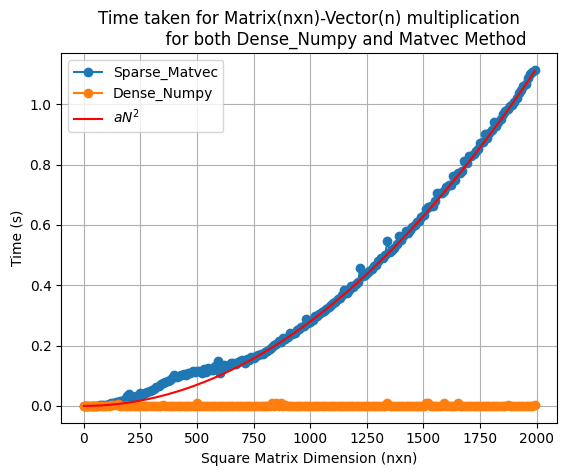

In [ ]:
n = np.arange(1,2000,10)
fig,ax=plt.subplots()

ax.plot(n,sparse_matvec_time,"-o", label="Sparse_Matvec")
ax.plot(n,dense_numpy_time,"-o", label="Dense_Numpy")
ax.plot(n,n_square, "-", label="$aN^{2}$" ,color="red")
#ax.plot(n,n_cube, "-", label="$bN^{3}$" )
ax.set_title("""Time taken for Matrix(nxn)-Vector(n) multiplication
              for both Dense_Numpy and Matvec Method""")

ax.set_ylabel("Time (s)")
ax.set_xlabel('Square Matrix Dimension (nxn)')
ax.legend()
ax.grid()

## **Question**
Briefly (1-2 sentence) comment on what your plot shows.

## **Comment**
The numpy dense matrix-vector mulitplication is faster than the matvec function, this is mainly because the matvec function uses nested loop. Since matvec uses a 2 nested-loop, its computational complexity scale like  $𝑂(𝑛^{2})$ hence we can try fitting $a𝑛^{2}$ to the matvec timeplot and it shows that the time taken for our matvec function scales like $n^{2}$ where n is the Matrix Dimension.

### **Next Task**
For a matrix of your choice and a random vector, use Scipy’s gmres and cg sparse solvers to solve a matrix problem using
your CSR matrix. Check if the two solutions obtained are the same. Briefly comment (1-2 sentences) on why the solutions
are or are not the same (or are nearly but not exactly the same).

In [ ]:
rand_mat=scipy.sparse.random(10,10,density=0.4)
rand_mat_CSR = CSRMatrix(rand_mat)
rand_vec = np.random.rand(10)


In [ ]:
# use Scipy's gmres to solve matrix problem using CSR matrix
gmres_sol, gmres_converg_inf = scipy.sparse.linalg.gmres(rand_mat,rand_vec)

In [ ]:
# Checking gmres accuracy
assert np.allclose(np.dot(rand_mat.toarray(),gmres_sol),rand_vec)

In [ ]:
# use Scipy cg to solve matrix problem using CSR matrix
cg_sol, cg_converg_inf = scipy.sparse.linalg.cg(rand_mat,rand_vec)


In [ ]:
# Checking cg accuracy
assert np.allclose(np.dot(rand_mat.toarray(),cg_sol),rand_vec)

AssertionError: 

## **Briefly comment (1-2 sentences) on why the solutions**
GMRES and CG solver uses different iterative methods (GMRES solver works for general matrices while CG solver works only for symmetric positive positive definite matrices), leading to differences in numerical precision and convergence behaviour. Therefore if the random generated matrix is not positive definite (very likely), CG solution will not be equal to the correct solution hence assert statement will give an error syntax for CG solver solution.

## **Part 2: Implementing a custom matrix**
**Implement a Scipy LinearOperator for matrices of this form.** Your implementation must include a matrix-vector product
(matvec) and the shape of the matrix (self.shape), but does not need to include an \__add__ function. In your implementation
of matvec, you should be careful to ensure that the product does not have more computational complexity then necessary.

In [ ]:
# define a class for the custom matrix

class CustomMatrix(LinearOperator):
    def __init__(self,T,W,diag):

      '''
      Construct matrix A
      '''

      # Condition for A=TW to be valid
      assert T.shape == np.transpose(W).shape
      assert W.shape[0] == T.shape[1] == 2
      assert diag.shape[0] == diag.shape[0]

      # Assigning attributes

      # Matrix A have dimension 2nx2n
      two_n = 2*diag.shape[0]
      self.shape = (two_n,two_n)
      self.dtype = diag.dtype
      self.diag = diag

      # A_Tilde is the bottom right dense matrix constructed from T@W
      self.A_Tilde = T @ W
      self.T_attribute = T
      self.W_attribute = W

    def _matvec(self,vector):
      """
      Matrix-vector Multiplication between A_Tilde and vector
      """

      # Condition for Matrix-vector multiplication
      assert self.shape[1] == vector.shape[0]

      # Assigning vector data type
      vector.dtype = self.dtype

      # Matvec multiplication

      # Top_left diagonal matrix calculation
      TL_diag = self.diag * vector[0:int(len(vector)/2)]

      # Bottom_right dense matrix calculation T @ (W @ vector)
      BR_dense=np.dot(self.T_attribute,np.dot(self.W_attribute,
                                              vector[int(len(vector)/2):]))

      result =  np.append(TL_diag,BR_dense)

      return result



### Testing the CustomMatrix Matvec function


In [ ]:
# Test the CustomMatrix Matvec function by comparing to a dense matvec
# computation

n=8
W = np.random.rand(2,n)
T = np.random.rand(n,2)
diag = np.random.rand(n)

A_Tilde = T@W

vec_rand = np.random.rand(2*n)

# CustomMatrix
custom_mat = CustomMatrix(T=T,W=W,diag=diag)
Custom_matvec = custom_mat @ vec_rand

# Dense Matrix method
Dense_mat = np.zeros((2*n,2*n))

for i in range(n):
    Dense_mat[i,i] = diag[i]

for i in range(n,2*n):
    for j in range(n,2*n):
        Dense_mat[i,j] = A_Tilde[i-n,j-n]

Dense_Matvec = Dense_mat @ vec_rand

# Checking CustomMatrix Matvec function
assert np.allclose(Custom_matvec,Dense_Matvec)

### Comment
The CustomMatrix Matvec function is working as expected

### **Next Task**

For a range of values of n, create matrices where the entries on the diagonal of the top-left block and in the matrices T and W are random numbers. For each of these matrices, compute matrix-vector products using your
implementation and measure the time taken to compute these. Create an alternative version of each matrix, stored using a
Scipy or Numpy format of your choice，and measure the time taken to compute matrix-vector products using this
format.

In [ ]:
# generate a range of values of n
n = np.arange(2,1000,1)

# create storage for custom_list due to different n value
custom_list = []

for i in range(2,1000,1):
    for j in range(len(n)):
        W_n = np.random.rand(2,j)
        T_n = np.random.rand(j,2)
        diag = np.random.rand(j)

        A_Tilde = T@W
        vec_n = np.random.rand(2*i)

In [ ]:
# generate a range of values of n
n = np.arange(2,1000,1)

# create storage for different n value
T_list = []
W_list = []
diag_list = []
A_Tilde_list = []
vec_list =[]

custom_list = []
Dense_list = []
# loop through n values to create custom matrix A
for i in range(len(n)):
    diag = np.random.rand(i)
    T_n = np.random.rand(i,2)
    W_n = np.random.rand(2,i)
    A_Tilde_n = T@W
    vec_n = np.random.rand(2*i)
    T_list.append(T_n)
    W_list.append(W_n)
    diag_list.append(diag)
    A_Tilde_list.append(A_Tilde_n)
    vec_list.append(vec_n)

    # Build dense_matrix
    dense_mat_n = np.block([[np.diag(diag),np.zeros((i,i))],
                            [np.zeros((i,i)),np.dot(T_n,W_n)]])
    Dense_list.append(dense_mat_n)

# Create custom matrices
for i in range(len(n)):
    custom_list.append(CustomMatrix(T=T_list[i],W=W_list[i],diag=diag_list[i]))

# Timing the time taken for CustomMatrix Matvec operation
custom_time = []
for i in range(len(custom_list)):
    t_custom=timeit("custom_list[i]@vec_list[i]",globals=globals(),number=1)
    custom_time.append(t_custom)

# Timing the time taken for Numpy-Dense Matrix & Numpy-Matvec
numpy_dense_time = []
for i in range(len(Dense_list)):
    t_dense=timeit("Dense_list[i]@vec_list[i]",globals=globals(),number=1)
    numpy_dense_time.append(t_dense)

In [ ]:
# Perform a test to verify that both Matvec method gives the same result via
# custom_matrix and Numpy_Dense_matrix
for i in range(len(custom_list)):
    assert np.allclose(custom_list[i]@vec_list[i],Dense_list[i]@vec_list[i])

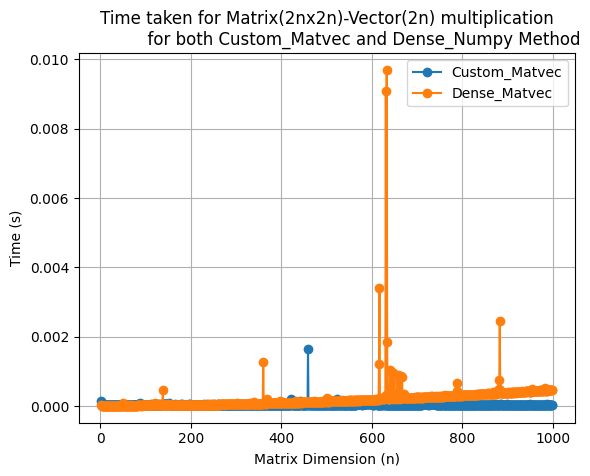

In [ ]:
fig,ax1=plt.subplots()

ax1.plot(n,custom_time,"-o", label="Custom_Matvec")
ax1.plot(n,numpy_dense_time,"-o", label="Dense_Matvec")

ax1.set_title("""Time taken for Matrix(2nx2n)-Vector(2n) multiplication
              for both Custom_Matvec and Dense_Numpy Method""")

ax1.set_ylabel("Time (s)")
ax1.set_xlabel('Matrix Dimension (n)')

plt.legend()
plt.grid()
plt.show()

### LogLog plot of the time taken for Matrix (2nx2n)-Vector(2n) multiplication for both Custom and Dense_numpy matrix

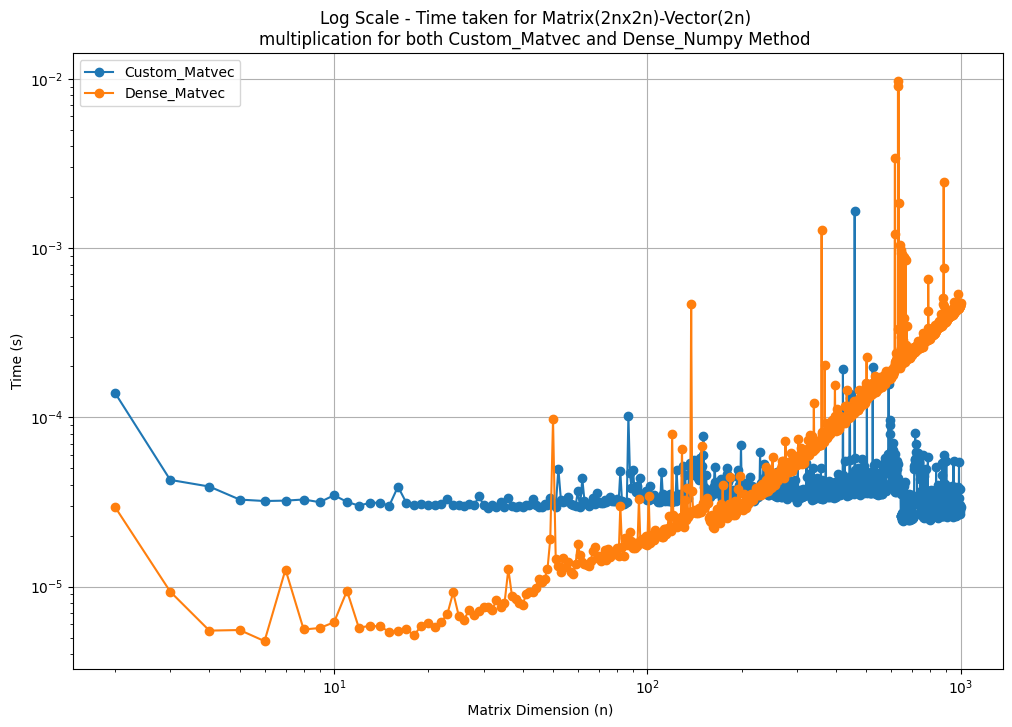

In [ ]:
fig,ax2=plt.subplots(figsize=(12,8))

ax2.plot(n,custom_time,"-o", label="Custom_Matvec")
ax2.plot(n,numpy_dense_time,"-o", label="Dense_Matvec")

ax2.set_title("""Log Scale - Time taken for Matrix(2nx2n)-Vector(2n)
multiplication for both Custom_Matvec and Dense_Numpy Method """)

ax2.set_ylabel("Time (s)")
ax2.set_xlabel(' Matrix Dimension (n)')

ax2.set_yscale('log')
ax2.set_xscale('log')

plt.legend()
plt.grid()
plt.show()

### **Question**
Comment (2-4 sentences) on what your plot shows, and why you
think one of these methods is faster than the other (or why they take the same amount of time if this is the case).

### **Comment**

As shown on the graph, the Custom_Matvec is faster than the Dense_Matvec for large matrix sizes (after roughly n= 300). The reason for this is because Custom_Matvec optimises the Matrix-Vector multiplication by leveraging the sparse matrix structure, avoiding unnecessary computations involving zero elements, for example, instead of taking the multiplication of the whole matrix with the vector, we can perform multiplication on the Top_left section of the matrix and Bottom_Right section of the matrix with the vector. On the other hand, the dense matrix approach includes all elements, leading to increased computational overhead for large matrices. For small matrix-vector multiplication, the difference between Custom_Matvec and Dense_Matvec methods might be negligible because the overhead of managing sparse data structures outweighs computational savings.